In [3]:
import time
import odrive
from odrive.enums import *

odrv0 = odrive.find_any()

def CALIB():
    print("starting calibration...")
    time.sleep(1)
    odrv0.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    odrv0.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    while odrv0.axis0.current_state != AXIS_STATE_IDLE:
        time.sleep(0.1)
    while odrv0.axis1.current_state != AXIS_STATE_IDLE:
        time.sleep(0.1)

    print("setting params axis 0...")
    odrv0.axis0.encoder.set_linear_count(0)
    odrv0.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

    print("setting params axis 1...")
    odrv0.axis1.encoder.set_linear_count(0)
    odrv0.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

def STOP():
    odrv0.axis0.requested_state = AXIS_STATE_IDLE
    odrv0.axis1.requested_state = AXIS_STATE_IDLE
    

In [5]:
CALIB()

starting calibration...
setting params axis 0...
setting params axis 1...


In [ ]:
STOP()

In [2]:
import sys
import odrive
import can
import struct
import socket
import time
import numpy as np
from odrive.enums import *
from enum import Enum

struct_format = ">6f14?"

# can_front = can.interface.Bus(channel='can0', bustype='socketcan')
can_back = can.interface.Bus(channel='can0', bustype='socketcan')

class Commands(Enum): #ODrive CAN cmd_id
    EMERGENCY_STOP = 0x002
    MOTOR_ERROR = 0x003
    ENCODER_ERROR = 0x004
    AXIS_REQUESTED_STATE = 0x007
    ENCODER_COUNT = 0x00A
    INPUT_POS = 0x00C
    REBOOT = 0x016
    VBUS_VOLTAGE = 0x017
    CLEAR_ERRORS = 0x018
    LINEAR_COUNT = 0x019

class State(Enum): #ODrive CAN data
    IDLE = 1
    FULL_CALIBRATION_SEQUENCE = 3
    CLOSED_LOOP_CONTROL = 8

class Joint(Enum): #Axis ID
    FL_hip = 0
    FL_upper = 1
    FL_lower = 2
    FR_hip = 3
    FR_upper = 4
    FR_lower = 5
    BL_hip = 6
    BL_upper = 7
    BL_lower = 8
    BR_hip = 9
    BR_upper = 10
    BR_lower = 11

def odrive_can_cmd(node_id, cmd_id, data=[], format=''): #convert to arbitration ID
    data_frame = struct.pack(format, *data)
    msg = can.Message(arbitration_id=((node_id << 5) | cmd_id), data=data_frame, is_extended_id=False)
    # can_front.send(msg)
    can_back.send(msg)

odrive_can_cmd(Joint.BL_hip.value, Commands.AXIS_REQUESTED_STATE.value, [State.FULL_CALIBRATION_SEQUENCE.value], 'h')

/tmp/ipykernel_19690/2637229940.py:14: DeprecationWarning: The 'bustype' argument is deprecated since python-can v4.2.0, and scheduled for removal in python-can v5.0.0. Use 'interface' instead.
  can_back = can.interface.Bus(channel='can0', bustype='socketcan')
SocketcanBus was not properly shut down


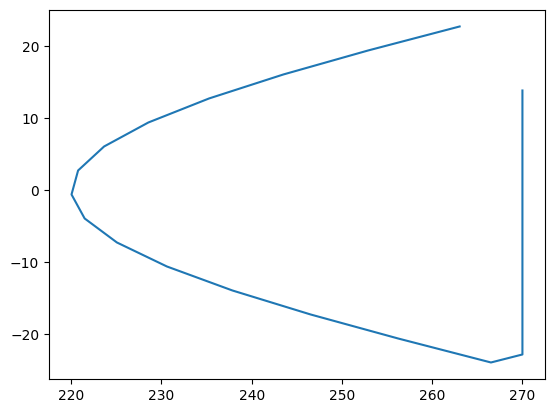

'\nfrom celluloid import Camera\ncamera = Camera(fig)\nprint(x_points)\nprint(y_points)\nfor i in range(1, len(x_points)):\n    x_0 = x_points[i-1]\n    x_1 = x_points[i]\n    y_0 = y_points[i-1]\n    y_1 = y_points[i]\n\n    curr_t = 0\n    interp_x = (x_1 - x_0) / 10\n    x = x_0\n    interp_y = (y_1 - y_0) / 10\n    y = y_0\n    for e in range(10):\n        x += interp_x\n        y += interp_y\n        plt.scatter(x, y, c="blue")\n        camera.snap()\n'

In [6]:
import math
import time
L1 = 160
L2 = 160
def q1q2_from_xy(x, y):
    xD_mag = math.sqrt(x*x + y*y)
    c2 = (xD_mag * xD_mag - L1 * L1 - L2 * L2) / (2 * L1 * L2)
    if abs(c2) > 1:
        return None
    if c2 == 1:
        return math.atan2(y, x), 0, math.atan2(y, x), 0
    q2_1 = 1 * math.acos( c2 )
    q2_2 = -1 * math.acos( c2 )
    theta = math.atan2(y, x)
    q1_1 = theta - math.atan2(L2 * math.sin(q2_1), L1 + L2 * math.cos(q2_1))
    q1_2 = theta - math.atan2(L2 * math.sin(q2_2), L1 + L2 * math.cos(q2_2))
    return q1_1, q2_1, q1_2, q2_2
T = 0
speed = 3
a = speed
b = L1 + L2 - 50
r = 50
c = 50

x_points = []
y_points = []

for i in range(1):
    while T <= 3.0 * a / 2.0 - 1:
        x = b
        y0 = (2 * r / a) * (abs( ((T+0)/3) % a - a / 2 ) - a/4)
        y1 = (2 * r / a) * (abs( ((T+1)/3) % a - a / 2 ) - a/4)
        y2 = (2 * r / a) * (abs( ((T+2)/3) % a - a / 2 ) - a/4)
        y3 = (2 * r / a) * (abs( ((T+3)/3) % a - a / 2 ) - a/4)

        _, _, q1_2_0, q2_2_0 = q1q2_from_xy(x, y0)
        _, _, q1_2_1, q2_2_1 = q1q2_from_xy(x, y1)
        _, _, q1_2_2, q2_2_2 = q1q2_from_xy(x, y2)
        _, _, q1_2_3, q2_2_3 = q1q2_from_xy(x, y3)

        T += 3e-1
        # time.sleep(0.03)
        x_points.append(x)
        y_points.append(y1)
    while T <= 3.0 * a - 1:
        x0 = 1 * c * math.sin(2 * math.pi * (T+0) / (3*a)) + b
        x1 = 1 * c * math.sin(2 * math.pi * (T+1) / (3*a)) + b
        x2 = 1 * c * math.sin(2 * math.pi * (T+2) / (3*a)) + b
        x3 = 1 * c * math.sin(2 * math.pi * (T+3) / (3*a)) + b

        y0 = (2 * r / a) * (abs( ((T+0)/3) % a - a / 2 ) - a/4)
        y1 = (2 * r / a) * (abs( ((T+1)/3) % a - a / 2 ) - a/4)
        y2 = (2 * r / a) * (abs( ((T+2)/3) % a - a / 2 ) - a/4)
        y3 = (2 * r / a) * (abs( ((T+3)/3) % a - a / 2 ) - a/4)

        _, _, q1_2_0, q2_2_0 = q1q2_from_xy(x0, y0)
        _, _, q1_2_1, q2_2_1 = q1q2_from_xy(x1, y1)
        _, _, q1_2_2, q2_2_2 = q1q2_from_xy(x2, y2)
        _, _, q1_2_3, q2_2_3 = q1q2_from_xy(x3, y3)

        T += 3e-1
        # time.sleep(0.03)
        x_points.append(x1)
        y_points.append(y1)
    T = 0


import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(x_points, y_points)
plt.show()
"""
from celluloid import Camera
camera = Camera(fig)
print(x_points)
print(y_points)
for i in range(1, len(x_points)):
    x_0 = x_points[i-1]
    x_1 = x_points[i]
    y_0 = y_points[i-1]
    y_1 = y_points[i]

    curr_t = 0
    interp_x = (x_1 - x_0) / 10
    x = x_0
    interp_y = (y_1 - y_0) / 10
    y = y_0
    for e in range(10):
        x += interp_x
        y += interp_y
        plt.scatter(x, y, c="blue")
        camera.snap()
"""

# from IPython.display import HTML
# animation = camera.animate()
# HTML(animation.to_html5_video())

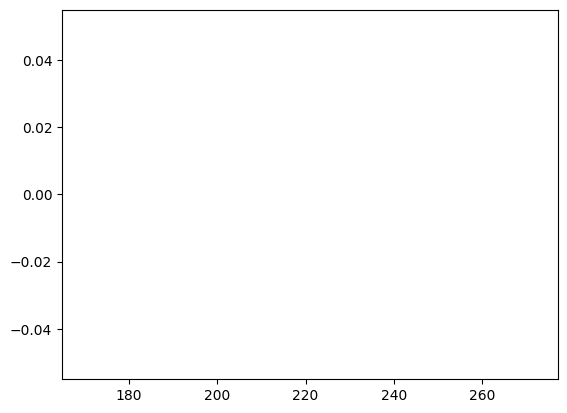

In [33]:
T = 0
b = L1 + L2 - 50
a = -100

max_q1 = 0
min_q1 = 0
max_q2 = 0
min_q2 = 0

x_points = []
y_points = []

for i in range(1):
    while T < 1:
        q1_1, q2_1, q1_2, q2_2 = 0, 0, 0, 0
        x = -a * T + a + b
        y = 0
        q1_1, q2_1, q1_2, q2_2 = q1q2_from_xy(x, y)

        max_q1 = max(math.degrees(q1_2), max_q1)
        min_q1 = min(math.degrees(q1_2), min_q1)
        max_q2 = max(math.degrees(q2_2), max_q2)
        min_q2 = min(math.degrees(q2_2), min_q2)
        
        T += 3e-2
        # time.sleep(0.03)
        x_points.append(x)
        y_points.append(y)
    while T >= 0:
        q1_1, q2_1, q1_2, q2_2 = 0, 0, 0, 0
        x = -a * T + a + b
        y = 0
        q1_1, q2_1, q1_2, q2_2 = q1q2_from_xy(x, y)

        max_q1 = max(math.degrees(q1_2), max_q1)
        min_q1 = min(math.degrees(q1_2), min_q1)
        max_q2 = max(math.degrees(q2_2), max_q2)
        min_q2 = min(math.degrees(q2_2), min_q2)

        T -= 3e-2
        time.sleep(0.03)
        x_points.append(x)
        y_points.append(y)

from celluloid import Camera
import matplotlib.pyplot as plt
fig = plt.figure()
camera = Camera(fig)
for i in range(len(x_points)):
    x = x_points[i]
    y = y_points[i]
    plt.scatter(x, y)
    camera.snap()

from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())

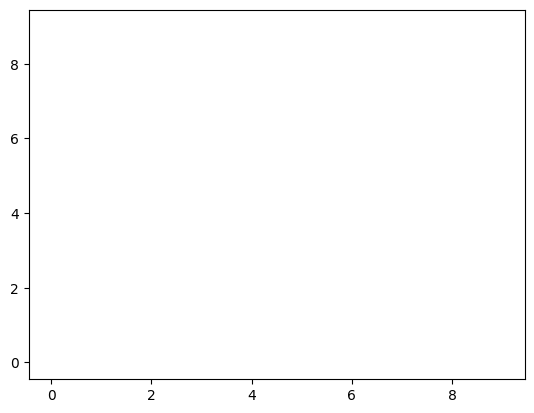

In [7]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
animation = camera.animate()
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())